In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.manifold.t_sne import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import mpl_toolkits.mplot3d.axes3d as p3
import re
import numpy as np

In [2]:
#Create DF
data = pd.read_csv('Consumer_Complaints.csv')
data.columns = ['date_received', 'product', 'sub_product', 'issue', 
                'sub_issue', 'consumer_complaint', 'company_response', 
                'company', 'state', 'zip', 'tags', 'consent', 'submitted_via', 'date_sent',
                'company_response', 'timely', 'disputed', 'complaint_id']

# Drop unnecessary columns
data.drop(columns=['sub_product', 'tags', 'complaint_id', 'consent'], 
          axis=1, inplace=True)

data = data.sort_values(by='date_received', ascending=False)

In [3]:
#Extract companies with asoociated complaints
company_complaints = data[['company', 'consumer_complaint']]\
    .dropna(subset=['consumer_complaint'])


#Create a dict of company -> complaints
complaint_company = {}
for index, company, complaint in company_complaints.itertuples():
    # Get rid of garbage values of 'xxxx' etc.
    complaint = re.sub(r'\bx\w*', '', complaint, flags=re.IGNORECASE)
    complaint = re.sub(r'\w*x*$', '', complaint, flags=re.IGNORECASE)
    complaint = re.sub(r'\b\d+\b', '', complaint)
    if complaint_company.get(company):
        complaint_company[company].add(complaint)
    else:
        complaint_company[company] = set()
        complaint_company[company].add(complaint)

# Create new DF from the dictionary, effectively grouping complaints by company
extracted = pd.DataFrame()
extracted['company'] = complaint_company.keys()
extracted['consumer_complaint'] = ['\n'.join(value) for value in complaint_company.values()]

In [4]:
# Run TF-IDF vectorizer on extracted complaint narratives
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='unicode', 
                             min_df=200)
X = vectorizer.fit_transform(extracted['consumer_complaint'])
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 3296, n_features: 1818


In [5]:
# Redunce # of components to 10
svd = TruncatedSVD(n_components=10)
# Normalize... l2 norm by default. Read sklearn doc for more
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
print()

Explained variance of the SVD step: 21%



In [6]:
# Method to plot enhanced dendrogram, based on SciPy's dendrogram
def better_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

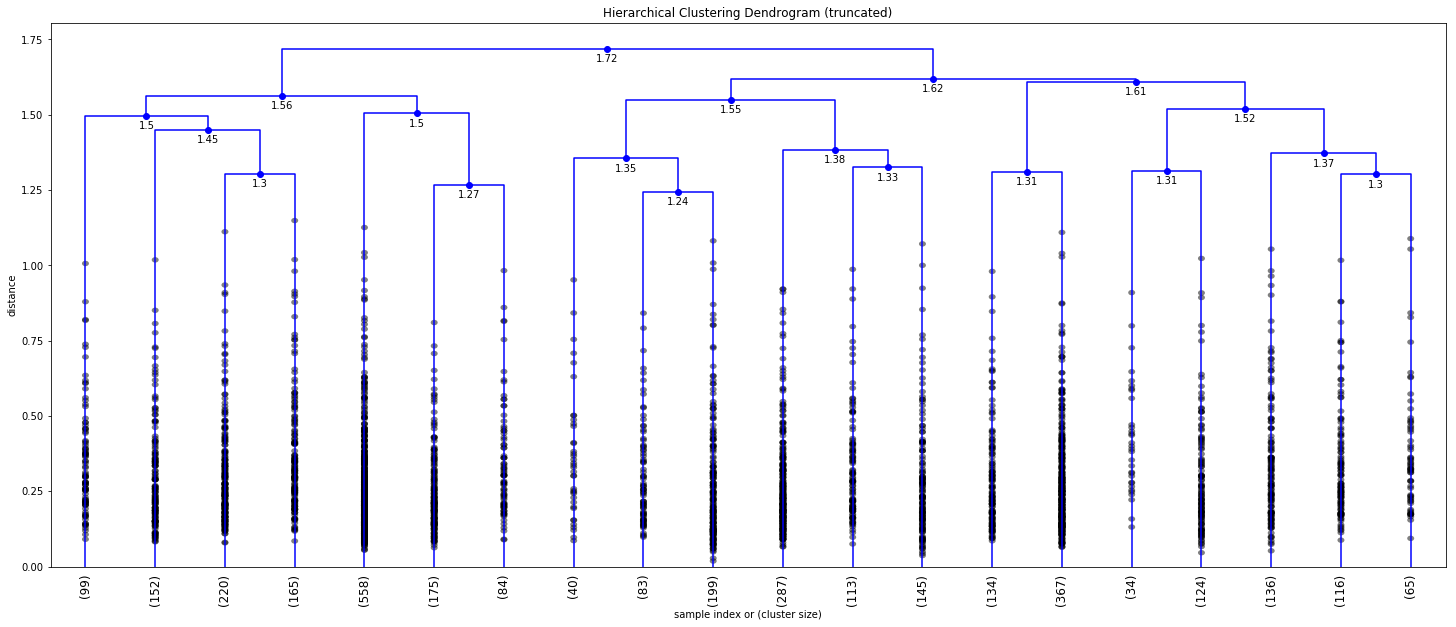

In [7]:
# Hierarchical - Complete linkage
Z = linkage(X, 'complete')
%matplotlib inline
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Complete)')
better_dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True  # to get a distribution impression in truncated branches
)
plt.show()

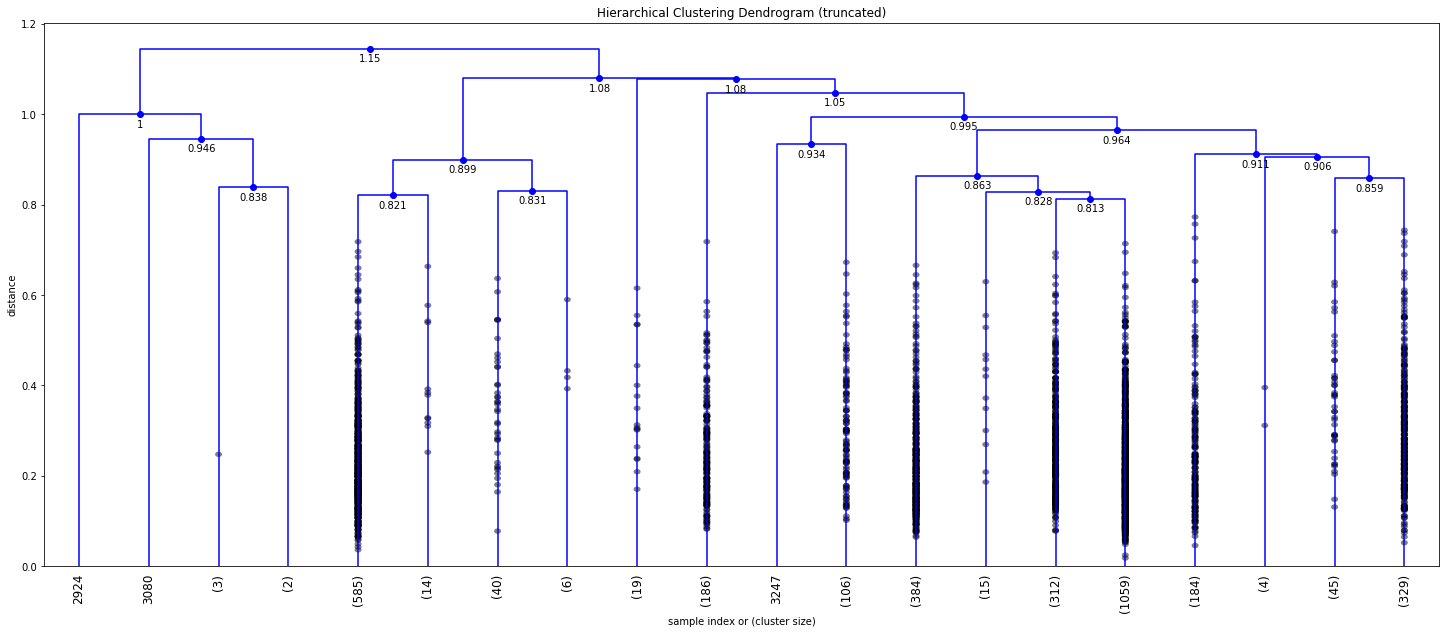

In [8]:
# Hierarchical - Average linkage
Z = linkage(X, 'average')
%matplotlib inline
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Complete)')
better_dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True  # to get a distribution impression in truncated branches
)
plt.show()

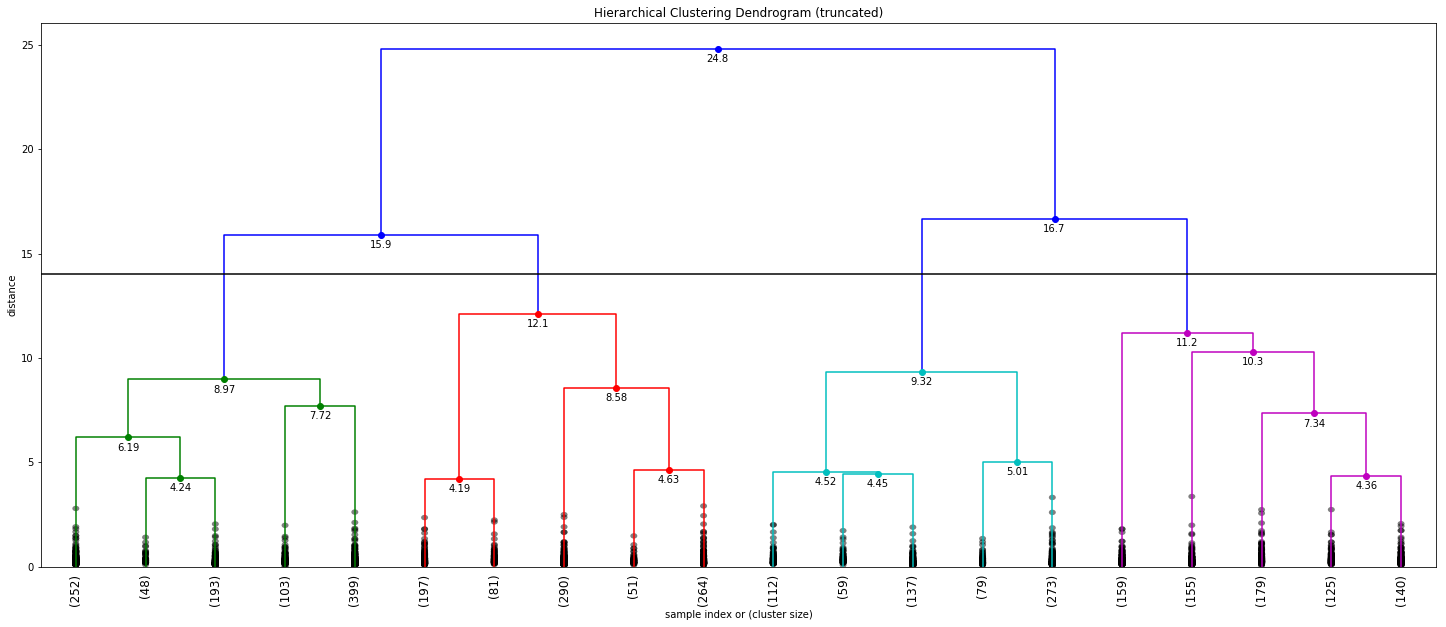

In [9]:
# Hierarchical - Ward linkage
Z = linkage(X, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')
better_dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    max_d=14
)
plt.show()

In [10]:
# Perform clustering
max_d = 14
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 4, 3, ..., 3, 3, 4], dtype=int32)

In [11]:
# Perform TSNE to reduce # of components to 3, for better visualization
X_t = TSNE(n_components=3).fit_transform(X)

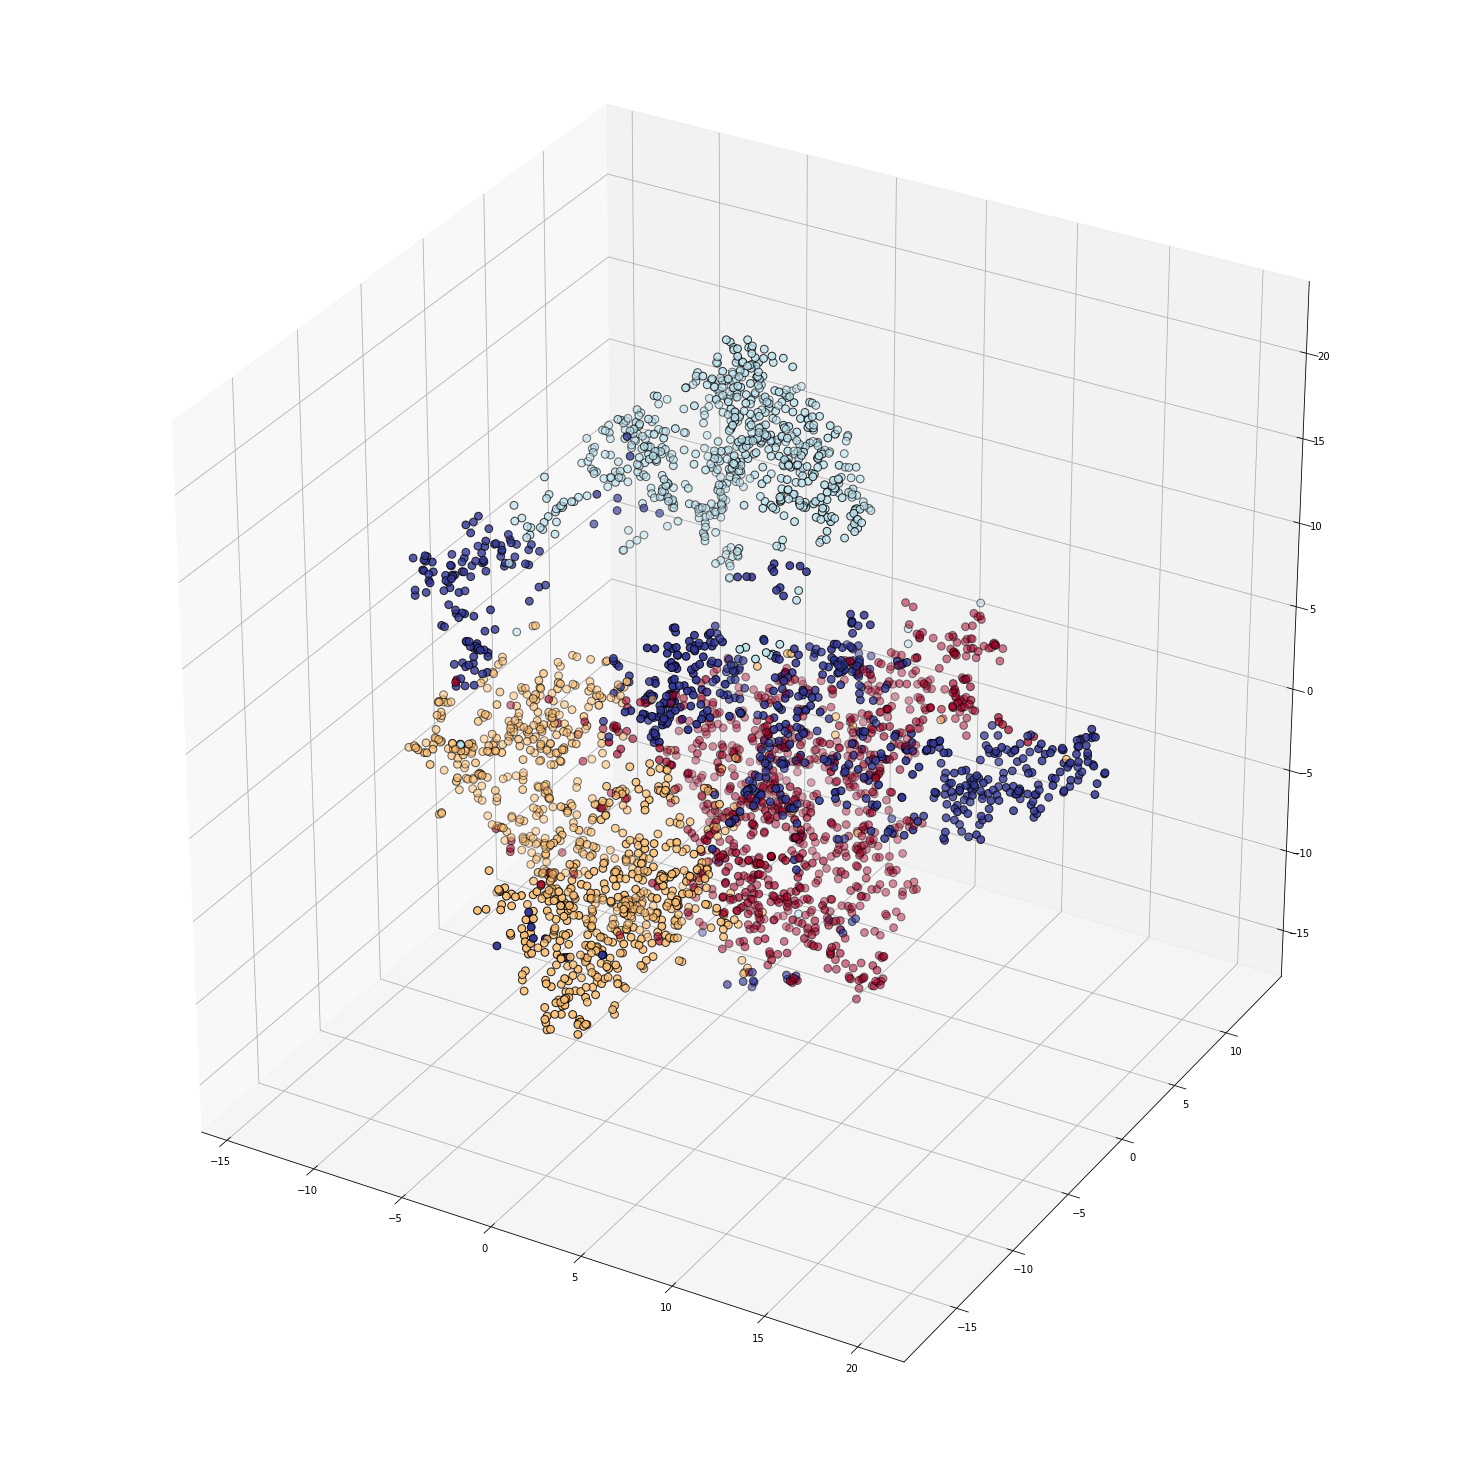

In [12]:
# Plot Ward linkage clustering results
fig = plt.figure(figsize=(20, 20))
ax = p3.Axes3D(fig)
ax.scatter(X_t[:, 0], X_t[:, 1], X_t[:, 2], c=clusters, s=60, edgecolor='k', cmap='RdYlBu')
plt.show()

In [13]:
extracted['cluster'] = clusters

#Group by cluster

grouped = extracted['company'].groupby(extracted.cluster).apply(set)
print(grouped)

cluster
1    {HireRight Solutions, Inc., Williams, Alexande...
2    {Sullivan & Terranova, Cooling & Winter LLC, J...
3    {JET DIRECT FUNDING CORP., US MORTGAGE CORPORA...
4    {Affiliated Management Services, VW Credit, Pr...
Name: company, dtype: object


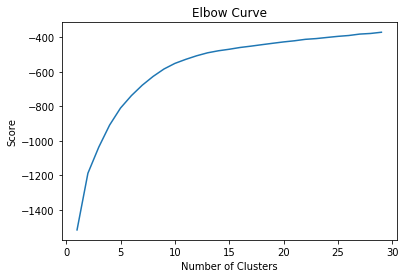

In [14]:
# K-Means
num_clusters = range(1, 30)
kmeans = [KMeans(n_clusters=i) for i in num_clusters]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [15]:
final_cluster=KMeans(n_clusters=12).fit(X)
labels = final_cluster.labels_
extracted['cluster'] = labels
#Group by cluster
grouped = extracted['company'].groupby(extracted.cluster).apply(set)
grouped

cluster
0     {Resource Management Group, Streamline Recover...
1     {M H Loans Corporation, ACADEMY MORTGAGE CORPO...
2     {Systematic National Collection, Inc., JP Deve...
3     {Law Office of Linda Strumpf, Credit Bureau of...
4     {JET DIRECT FUNDING CORP., MORTGAGE FIRM, INC....
5     {Affiliated Management Services, HireRight Sol...
6     {Credit Services of Oregon, Inc., Sullivan & T...
7     {Professional Choice Recovery, Inc., Empowerme...
8     {Williams, Alexander & Associates, Inc, Mid-Mi...
9     {VW Credit, CarMax, Inc., CCB Credit Serivces,...
10    {Receivables Management Corporation of America...
11    {TMX Finance LLC, MoneyLion Inc., Amati & Asso...
Name: company, dtype: object

In [16]:
# Print top 5 terms in each cluster
original_space_centroids = svd.inverse_transform(final_cluster.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(12):
     print("Cluster %d:" % i, end='')
     for ind in order_centroids[i, :5]:
         print(' %s' % terms[ind], end=', ')
     print()

Cluster 0: debt,  number,  phone,  called,  company, 
Cluster 1: loan,  mortgage,  closing,  home,  lender, 
Cluster 2: debt,  collection,  account,  company,  received, 
Cluster 3: debt,  court,  law,  firm,  judgement, 
Cluster 4: mortgage,  loan,  payment,  home,  escrow, 
Cluster 5: credit,  report,  account,  company,  reporting, 
Cluster 6: told,  payment,  loan,  called,  said, 
Cluster 7: account,  bank,  card,  money,  check, 
Cluster 8: debt,  credit,  collection,  account,  report, 
Cluster 9: car,  vehicle,  payment,  loan,  credit, 
Cluster 10: debt,  collection,  credit,  insurance,  payment, 
Cluster 11: loan,  loans,  student,  payment,  payments, 
